# CH7 범주형 데이터 이진분류 경진대회

* 학습순서

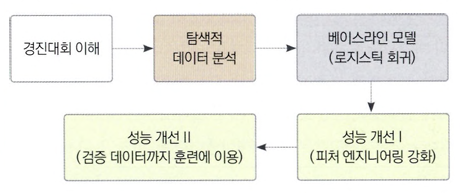

## 7.1 경진대회 이해  
(https://www.kaggle.com/c/cat-in-the-dat)  
### 경진대회의 overview/data에서 다음 정보를 얻을 수 있음
1. 피처는 모두 범주형(categorical)이다.
2. 피처의 종류
   - 이진(binary) 피처
   - 저차원의 or 고차원의 명목형(데이터 간 순위를 매길수 없는) 피처
   - 저차원의 or 고차원의 순서형 피처
   - 주기성을 지닌(cyclical) 피처
3. 피처 상세설명
   - bin_* : 이진 피처
   - nom_* : 명목형 피처
   - ord_* : 순서형 피처
   - day, month : 날짜 피처
   - 타깃값 : binary data
4. 경진대회의 목표: ***각 테스트 데이터의 타깃값이 1일 확률을 예측하기***

## 7.2 탐색적 데이터 분석

In [1]:
import pandas as pd
# 데이터 불러오기
data_path ='/kaggle/input/cat-in-the-dat/'
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [2]:
# 훈련 데이터 30만개, 테스트 데이터 20만개
train.shape, test.shape

((300000, 24), (200000, 23))

In [3]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


### 7.2.1 피처의 대략적인 구조 파악하기

In [4]:
#피처의 데이터타입/결측값개수/고윳값개수를 보기 위해 피처 요약표 생성
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    return summary
resumetable(train)

데이터셋 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


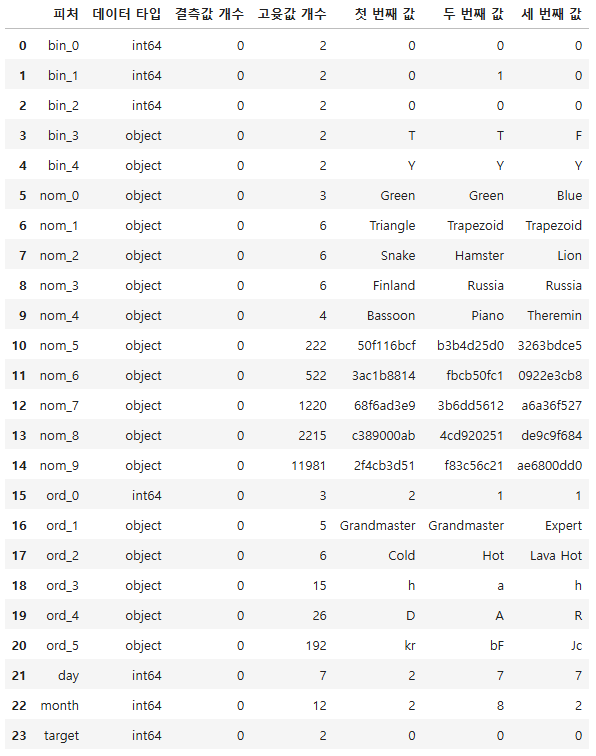

* 위 피처 요약표에서 다음 내용을 알 수 있음
  - 이진 피처(bin_)는 총 5개. 그 중 3개는 0/1값을 갖는다. 나머지는 T/F와 Y/N이다.
  - 명목형 피처(nom_)는 총 10개. 그 중 5개는 저차원(고윳값 개수 적음)이고, 나머지 5개는 고차원이다.
  - 순서형 피처(ord_)는 총 6개. 그 중 하나만 정수형이고 나머지는 object 타입이다. (참고: ord_3~ord_5는 알파벳 순으로 데이터 순서가 결정된다.)

In [5]:
# 순서형 피처의 각 고유값을 보며 자세히 파악
for i in range(6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'i

**위 고윳값을 통해 알 수 있는 것**
* ord_1 피처의 고윳값은 캐글 등급. Novice, Contributor, Expert, Master, Grandmaster 순으로 숫자에 맵핑(인코딩)하면 될듯
* ord_2 피처의 고윳값은 춥고 더운 정도. Freezing, Cold, Warm, Hot, 
Boiling Hot, Lava Hot 으로 숫자에 맵핑하면 될듯
* ord_3 ~ ord_5는 알파벳 순으로 인코딩 하면 될듯

### 7.2.2 시각화를 통한 피처의 중요도 파악
- 어떤 피처가 중요하고 어떤 고윳값이 타깃값에 영향을 많이 주는지 알기 위함
- 7.2.2에서는 타깃값 - 이진피처 - 명목형 피처 - 순서형 피처 순으로 그래프를 그려볼 것임

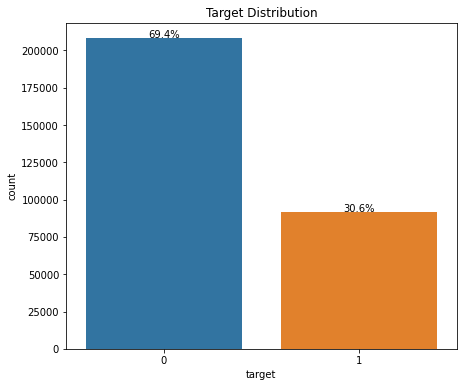

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline

# 타깃값 분포
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height() 
        width = patch.get_width() 
        left_coord = patch.get_x()
        percent = height/total_size*100 # 타깃값 비율
        # (x, y) 좌표에 텍스트 입력 
        ax.text(x=left_coord + width/2.0,
                y=height + total_size*0.001, 
                s=f'{percent:1.1f}%', 
                ha='center')
plt.figure(figsize=(7, 6))
ax = sns.countplot(x='target', data=train) 
write_percent(ax, len(train)) # 비율 표시 
ax.set_title('Target Distribution');

**타깃값 분포**
* 타깃값 0은 70% 가량 (20만개 넘음)
* 타깃값 1은 30% 가량 (9만개 정도)

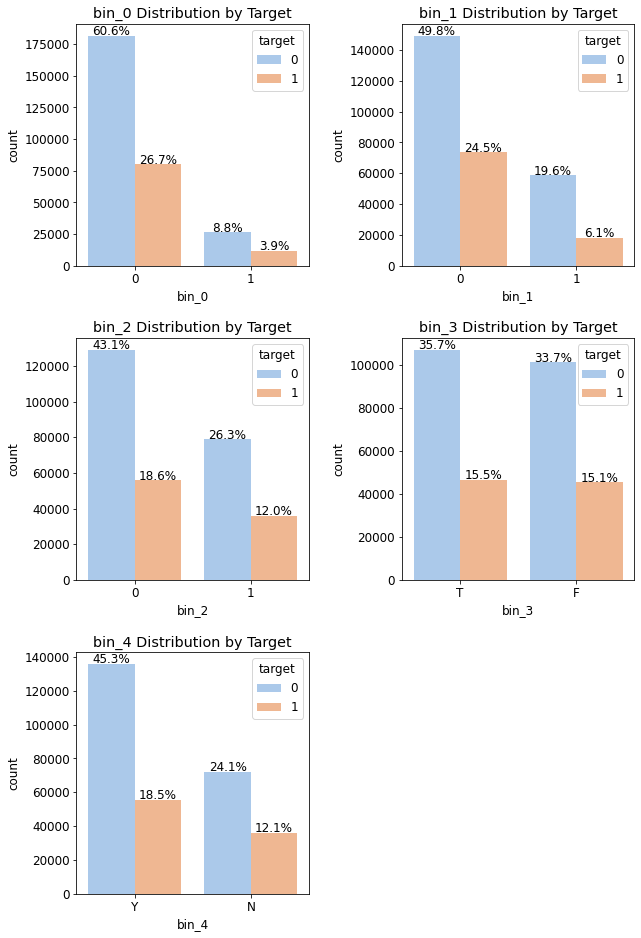

In [7]:
import matplotlib.gridspec as gridspec #여러 그래프를 격자 형태로 배치
# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치 
plt.figure(figsize=(10, 16)) # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정 
 
# 서브플롯 그리기 
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3' , 'bin_4'] # 피처 목록 

for idx, feature in enumerate(bin_features):  
    ax = plt.subplot(grid[idx]) # O
    
    # ax축에 타깃값 분포 카운트플롯 그리기 
    sns.countplot(x=feature, data=train, hue='target', palette='pastel', ax=ax)
    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목 설정  
    write_percent(ax, len(train)) # 비율 표시 

**이진 피처의 분포를 타깃값 별로 그려보기**
- bin_0 피처의 값이 0일 때, 타깃값의 분포를 보면  
  -> 타깃값0:타깃값1 = 60.6*(1/87.3):26.7*(1/87.3)=69.4:30.6 정도 됨.  
  -> 이는 전체 타깃값의 비율인 7:3과 유사함.  
- 다른 이진 피처에 대해서 동일하게 계산해 보면 타깃값 분포가 대체로 7:3 인것을 알 수 있음.  
  -> 이진 피처들은 특정 타깃값에 치우치지 않는다  
  -> **이진 피처들은 타깃값 예측에 큰 영향이 있지 않을 것이라 예상할 수 있다**

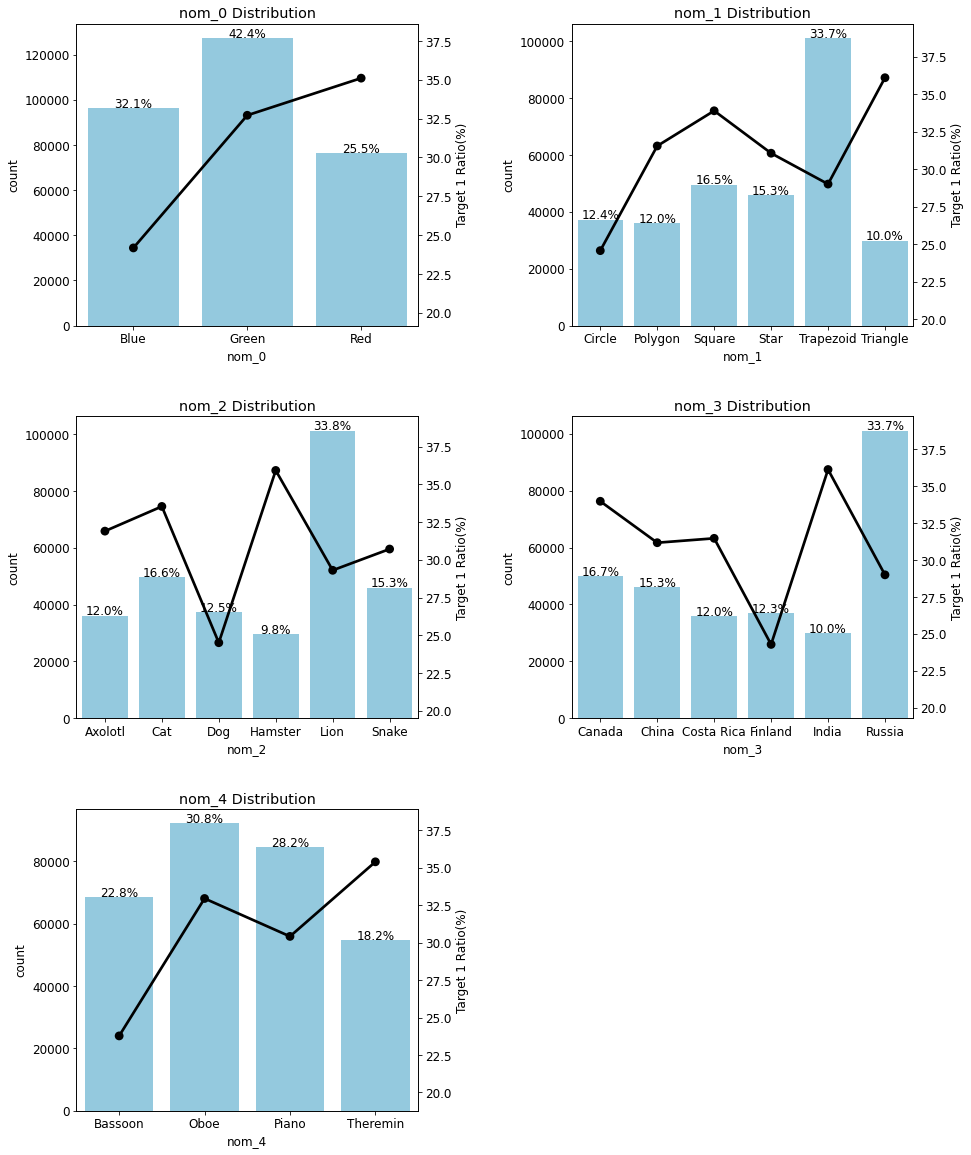

In [8]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성 
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab, order=crosstab[feature].values, color='black', legend=False) 
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1) # y축 범위 설정 0 
    ax2.set_ylabel('Target 1 Ratio(%)')

def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size=(15, 20)): 
    plt.figure(figsize=size) # 전체 Figure 크기 설정 
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치 
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features): # 
        ax = plt.subplot(grid[idx]) 
        crosstab = get_crosstab(df, feature) # 교차분석표 생성 
        
        # ax축에 타깃값 분포 카운트플롯 그리기 
        sns.countplot(x=feature, data=df, order=crosstab[feature].values, color='skyblue', ax=ax)
        
        write_percent(ax, len(df)) # 비율 표시 
        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기 
        ax.set_title(f'{feature} Distribution') # 그래프 제목 설정 

nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3' , 'nom_4'] # 드
plot_cat_dist_with_true_ratio(train, nom_features, num_rows=3, num_cols=2)

**위 그래프: 저차원 명목형 피처(nom_0 ~ nom_4)의 고윳값 분포와 타깃값 1의 비율**
- nom_0을 예시로 설명하자면
  피처의 고윳값 분포 (파란 막대)는 Blue:Green:Red = 32.1:42.4:25.5 이고,  
  각 고윳값에 따른 타깃값 1의 비율(검은색 포인트)은 Blue=0.24, ... 이다.  
  nom_0의 피처값이 blue 일때 타깃값의 24%는 1이고 76%는 0이라는 뜻.
- 위 그래프를 보면 nom_0 ~ nom_4 피처는 고윳값 별로 타깃값 1의 비율이 서로 다르다.
  즉 '**해당 피처들을 통해 타깃값을 예측하는 것이 의미있다**'는 뜻
  따라서 nom_0 ~ nom_4는 모두 모델링에 사용하도록 하겠음. 원-핫 인코딩 사용 예정
  
  
**고차원 명목형 피처(nom_5 ~ nom_9)**
- 고윳값 개수가 너무 많고 의미 없는 문자로 이루어져 있어 시각화 하기 어렵다
- 일단은 필요한 피처라 생각하고 모델링에 사용하도록 하겠음.
- 원-핫 인코딩 사용예정: 피처의 의미를 몰라 그룹화하기 어렵기 때문

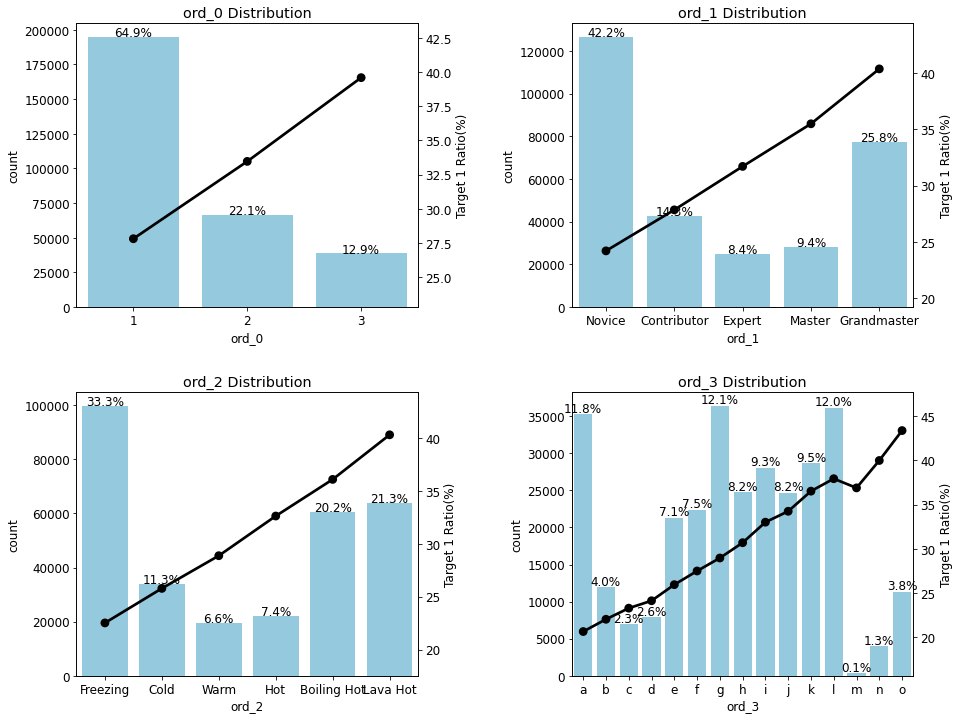

In [9]:
from pandas.api.types import CategoricalDtype
ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
 
# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)
 
# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3'] # 순서형 피처 
plot_cat_dist_with_true_ratio(train, ord_features, num_rows=2, num_cols=2, size=(15, 12))

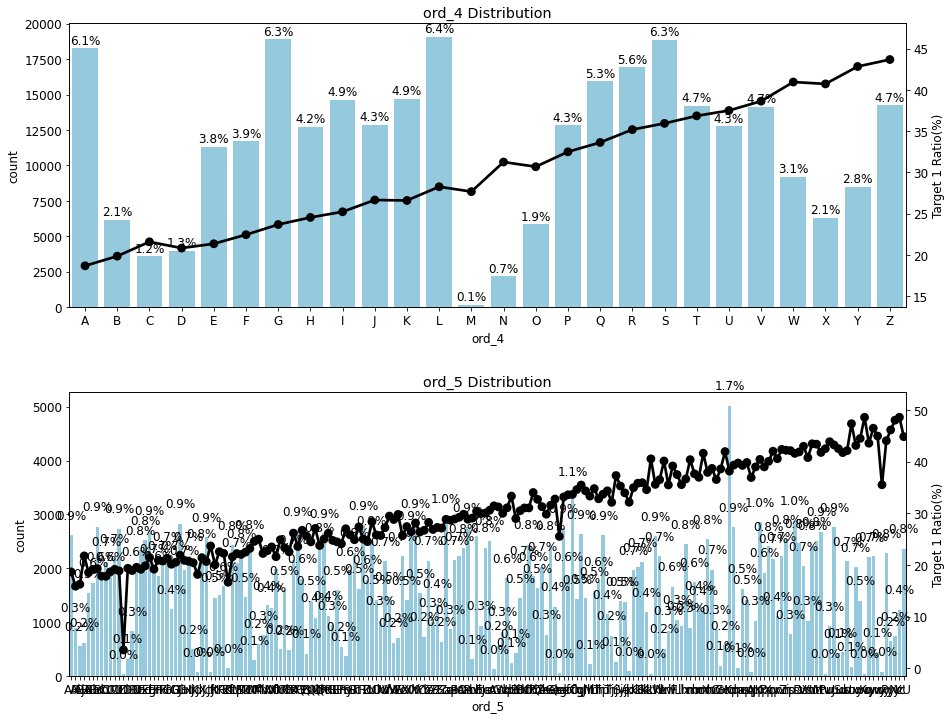

In [10]:
plot_cat_dist_with_true_ratio(train, ['ord_4', 'ord_5'], num_rows=2, num_cols=1, size=(15, 12))

**순서형 피처**
- 모든 순서형 피처의 고윳값 순서에 따라 타깃값 1의 비율이 증가하는 것을 알 수 있다.
- 즉 **모든 순서형 피처가 타깃값과 상관관계가 있다**
- 따라서 모델링 시 순서형 피처 모두를 사용하겠음

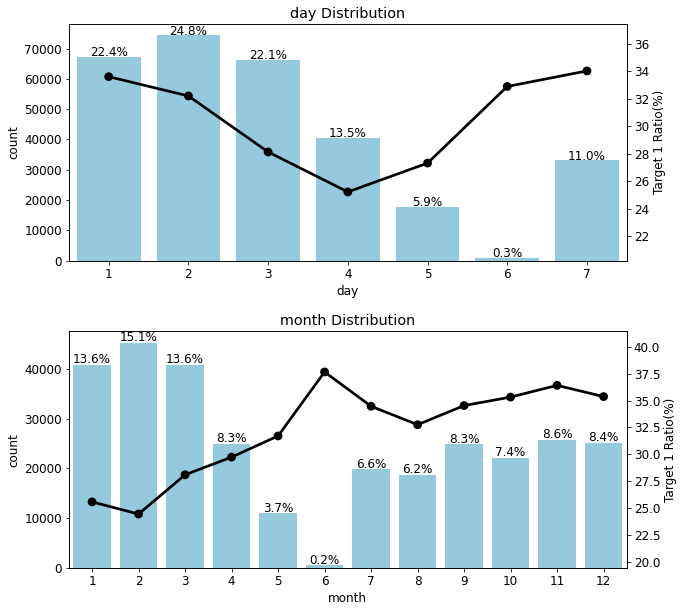

In [11]:
date_features = ['day', 'month']
plot_cat_dist_with_true_ratio(train, date_features, num_rows=2, num_cols=1, size=(10, 10))

**day & month 피처**
- day : 고윳값이 7개 이므로 '요일'이라 추측 가능
- month : 고윳값이 12개 이므로 '월'이라 추측 가능
- 요일/월 은 주기적으로 반복되는 순환형(cyclical) 데이터. 따라서 삼각함수 인코딩이 효과적일수도  
  -> 근데 저자가 미리 테스트 해본 결과 삼각함수 인코딩보다 원-핫 인코딩이 성능이 더 좋았다고 함.

## 7.3 베이스라인 모델
- 모든 피처를 원-핫 인코딩한 뒤, 로지스틱 회귀 모델로 베이스라인을 만들어 보겠음  
  (앞서 파악한 피처별 특징에 따른 인코딩은 7.4 절에서 보도록 하겠음)
- 프로세스는 다음과 같음
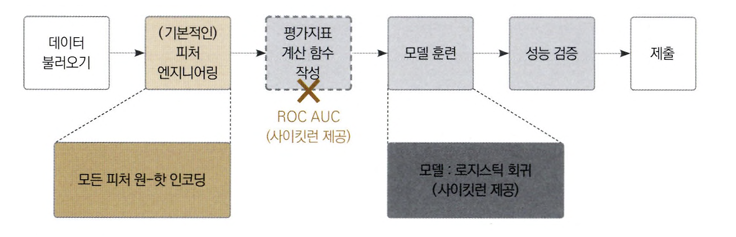

### 7.3.1 피처 엔지니어링 (원-핫 인코딩)
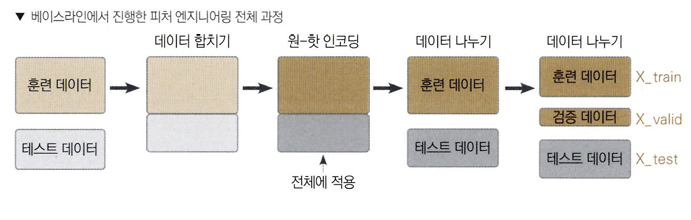
* 참고: 훈련데이터/검증데이터/테스트데이터 차이점은?
  
**1. 훈련 데이터 (Training Data)**  
역할: 모델이 학습하는 데 사용하는 데이터  
목적: 모델이 피처와 타깃값 간의 관계를 학습하여 예측할 수 있도록 합니다.  
설명: 훈련 데이터는 피처와 타깃값 모두 포함되어 있으며, 모델이 규칙이나 패턴을 배우기 위해 반복적으로 사용됩니다.  
**2. 검증 데이터 (Validation Data)**  
역할: 모델을 평가하고 하이퍼파라미터를 튜닝할 때 사용하는 데이터  
목적: 모델이 훈련 데이터에 과적합되지 않도록 하고, 성능을 최적화하는 데 도움을 줍니다.  
설명: 검증 데이터는 모델이 학습한 후에 잠시 테스트해 보는 데이터로, 하이퍼파라미터 최적화에 주로 사용됩니다. 모델 훈련 과정에서는 검증 데이터에 대한 성능을 기준으로 모델을 조정하며, 이를 통해 모델이 훈련 데이터에만 맞춰지지 않고 일반화되도록 만듭니다.  
**3. 테스트 데이터 (Test Data)**  
역할: 최종 모델의 성능을 확인하는 데 사용하는 데이터  
목적: 모델의 일반화 능력을 평가하여, 새로운 데이터에 대한 예측 성능을 측정합니다.  
설명: 테스트 데이터는 모델이 학습 및 튜닝 과정에서 전혀 보지 않은 데이터로, 최종 평가를 위해 따로 보관해 둡니다. 모델의 최종 예측 정확도나 성능을 확인하기 위한 실제 성능 측정용 데이터라고 할 수 있습니다.

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

##########(1) 데이터 불러오기
data_path ='/kaggle/input/cat-in-the-dat/'
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

##########(2) 문자 데이터를 숫자 데이터로 인코딩 하는 작업 (머신러닝 모델은 문자인식 불가)

####(2.1) 편의상 훈련 데이터와 테스트 데이터를 합쳐서 한꺼번에 인코딩 하겠음
all_data = pd.concat([train, test]) # 훈련 데이터와 테스트 데이터 합치기
all_data = all_data.drop('target', axis=1) # 타깃값 제거 
# -> train 데이터에는 target 컬럼이 원래 없었으므로 all_data 상에는 NaN으로 기록되 있을 것. 따라서 인코딩을 위해 target 컬럼만 잠시 제거한다

encoder = OneHotEncoder() # 원-핫 인코더 생성 
all_data_encoded = encoder.fit_transform(all_data)

####(2.2) 훈련데이터 / 테스트데이터 분리하기
num_train = len(train) # 훈련 데이터 개수
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_encoded[:num_train] # 0~num_train - 1행
X_test = all_data_encoded[num_train:] # num_train시가지막 행
y = train['target']

####(2.3) 훈련 데이터 -> 훈련데이터와 검증데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.1, stratify=y, random_state=10)

### 7.3.2 모델 훈련
- 로지스틱 회귀 모델을 사용: 선형회귀를 응용해 분류를 수행하는 모델

  
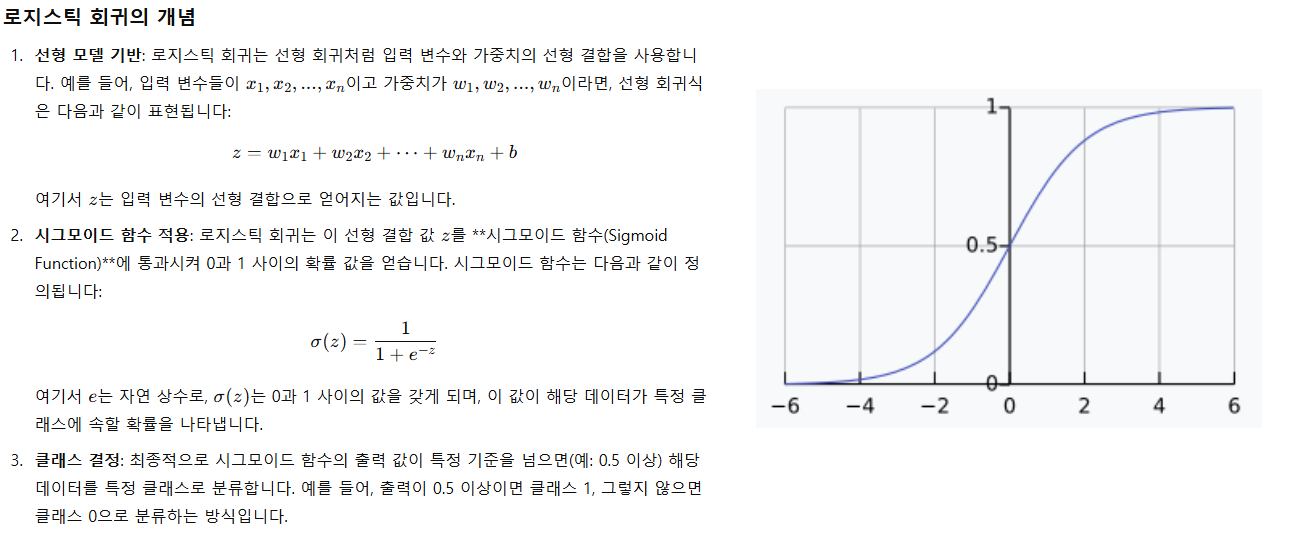훈련

In [13]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000, random_state=42) # 모델 생성 
logistic_model.fit(X_train, y_train) # 모델 훈련

LogisticRegression(max_iter=1000, random_state=42)

### 7.3.3 모델 성능 검증
- 검증 데이터(valid data)로 모델 성능 보기

In [14]:
logistic_model.predict_proba(X_valid) # 타겟값이 0일 확률과 1일 확률을 array로 보여주는 함수

array([[0.23262216, 0.76737784],
       [0.91407764, 0.08592236],
       [0.83025174, 0.16974826],
       ...,
       [0.24875927, 0.75124073],
       [0.49441807, 0.50558193],
       [0.95661255, 0.04338745]])

In [15]:
from sklearn.metrics import roc_auc_score

# 검증 데이터 타깃값이 1일 확률 저장
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc: .4f}')

검증 데이터 ROC AUC :  0.7965


### 7.3.4 예측 및 결과 제출
- 테스트 데이터(test data)를 활용해 타깃값이 1일 확률 예측

In [16]:
# 타깃값 1일 확률 예측
y_preds = logistic_model.predict_proba(X_test)[:, 1]
# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission.csv')

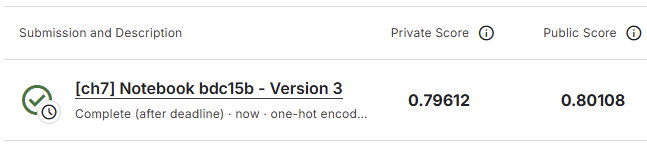  
...  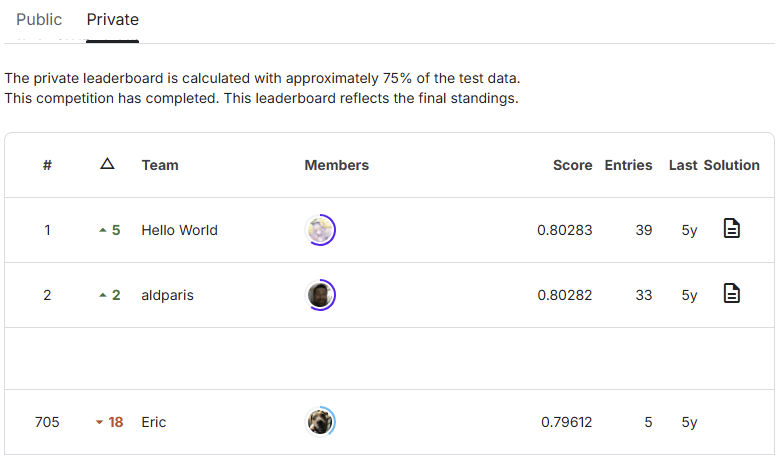g)
- private 점수가 최종점수
- 리더보드의 1등 점수와 0.00671점 차이 나는데 705등임.